In [1]:
import json
import matplotlib.pyplot as plt
from numpy import array, zeros
import scipy
from glob import glob
import os
import cv2
import numpy as np
import torch
import torchvision as vision
from torchvision import transforms
import joint_transforms
from torch.utils import data
from imageio import imread
from imageio import imwrite

In [2]:
## check PyTorch GPU support
print (torch.cuda.get_device_name(0))

GeForce GTX 1080 Ti


In [3]:
import training_utils

In [4]:
# IMG_PATH = '/media/data2TB/jeremyshi/data/cilia/train/data/'
# MASK_PATH = '/media/data2TB/jeremyshi/data/cilia/train/masks/'


def load_input(base, split):
    '''
    Helper function to get the foler path. Under base (could be train, val, or test).
    Return the path for under the folders of training imgs and masks.
    '''
    input_imgs = []
    masks_imgs = []
    all_hash = sorted(os.listdir(base + split + '/data/'))
    
    for imgHash in all_hash:
        inputs = glob(base + split + '/data/' + imgHash + '/*.png')
        input_imgs.append(array([imread(f, pilmode='RGB') for f in inputs]).mean(axis=0))
        if split != 'test':
            masks = glob(base + split + '/masks/' + imgHash + '.png')
            masks_imgs.append(array([imread(f, pilmode='I') for f in masks]))


    # check whether if they are good
    if split != 'test':
        if len(input_imgs) == 0 or len(masks_imgs) == 0:
            raise RuntimeError('Found 0 images, please check the data set')
        if len(input_imgs) != len(masks_imgs):
            raise RuntimeError('Must be the same amount of the input and mask images!')
        # reshape the mask
        for i in range(len(masks_imgs)):
            masks_imgs[i] = masks_imgs[i].reshape(masks_imgs[i][0].shape + (1, ))
            masks_imgs[i] = masks_imgs[i].astype(np.int32)

    # reshape the input
    for i in range(len(input_imgs)):
        # input_imgs[i] = input_imgs[i].reshape(input_imgs[i].shape + (1,))
        input_imgs[i] = input_imgs[i].astype(np.uint8)

    if split != 'test':
        return input_imgs, masks_imgs
    else:
        return input_imgs


ROOT = '/media/data2TB/jeremyshi/data/cilia/'
# loaded = load_input(ROOT, 'train')

In [5]:
# plt.imshow(loaded[0][1][:, :, 0])
# print(loaded[0][1])

In [6]:
class CiliaData(data.Dataset):
    '''
    From https://github.com/bfortuner/pytorch_tiramisu/blob/master/datasets/camvid.py and 
    https://github.com/ZijunDeng/pytorch-semantic-segmentation/blob/master/datasets/cityscapes.py
    PyTorch class of dataset for loading input and target data. 
    __init__ starts a class.
    __getitem__ builds iterator of pairs of input and target images.
    __len__ returns the length of the dataset
    '''
    def __init__(self, root, split='train', joint_transform=None,
                 input_transform=None, target_transform=None):
        self.root = root
        assert split in ('train', 'validate', 'test')
        self.split = split
        self.input_transform = input_transform
        self.target_transform = target_transform
        self.joint_transform = joint_transform
        if split != 'test':
            self.imgs, self.masks = load_input(self.root, split)
        else:
            self.imgs = load_input(self.root, split)
    
    def __getitem__(self, index):
        
        img = self.imgs[index]
        
        if self.split != 'test':
            target = self.masks[index]
        
            # transform the img and target into PIL images (for cropping etc.)
            toPIL = transforms.ToPILImage()
            img, target = toPIL(img), toPIL(target)

            # we need joint transform because we need to crop the same area
            if self.joint_transform is not None:
                img, target = self.joint_transform(img, target)
            if self.target_transform is not None:
                target = self.target_transform(target).long()
                
        if self.input_transform is not None:
            img = self.input_transform(img)
            
        if self.split != 'test':
            return img, target[0, :, :]
        else:
            return img
    
    def __len__(self):
        return len(self.imgs)


In [7]:
import joint_transforms

ROOT = '/media/data2TB/jeremyshi/data/cilia/'
train_joint_transformer = joint_transforms.Compose([
    joint_transforms.RandomSizedCrop(256), 
    joint_transforms.RandomHorizontallyFlip()
    ])

img_transform = transforms.Compose([
#     transforms.ToPILImage()
#     transforms.RandomCrop((256, 256)),
#     transforms.Resize((512,512)),
#       transforms.RandomHorizontalFlip(),
#       transforms.RandomVerticalFlip(),
#     transforms.Pad(16),
    transforms.ToTensor()  
])

cilia = CiliaData(ROOT,
                  joint_transform = train_joint_transformer, 
                  input_transform=img_transform,
                  target_transform=img_transform
                 )

In [8]:
print (len(cilia))


159


In [9]:
input_a, target_a = next(iter(cilia))

In [10]:
train_loader = data.DataLoader(cilia, batch_size=5, shuffle=True)


In [11]:
import torchvision

In [12]:
input_b, target_b = next(iter(train_loader))

In [13]:
input_b.size(), target_b.size()

(torch.Size([5, 3, 256, 256]), torch.Size([5, 256, 256]))

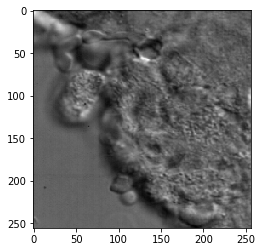

In [14]:
plt.imshow(input_b[0, 0, :, :], cmap='gray')

In [15]:
input_b[0, 0, :, :], target_b[0, :, :]

(
  0.5647  0.5647  0.5569  ...   0.3569  0.3608  0.3529
  0.5961  0.5961  0.5882  ...   0.3725  0.3765  0.3765
  0.6196  0.6235  0.6118  ...   0.3922  0.3882  0.3804
           ...             ⋱             ...          
  0.4078  0.4078  0.4039  ...   0.3725  0.3725  0.3686
  0.4078  0.4039  0.4078  ...   0.3961  0.3882  0.3804
  0.4118  0.4039  0.4039  ...   0.4039  0.4039  0.3843
 [torch.FloatTensor of size 256x256], 
     0     0     0  ...      1     1     1
     0     0     0  ...      1     1     1
     0     0     0  ...      1     1     1
        ...          ⋱          ...       
     0     0     0  ...      1     1     1
     0     0     0  ...      1     1     1
     0     0     0  ...      1     1     1
 [torch.LongTensor of size 256x256])

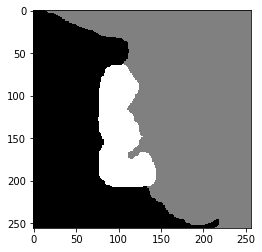

In [16]:
plt.imshow(target_b[0, :, :], cmap='gray')

## Training

In [17]:
LR = 1e-4
LR_DECAY = 0.995
DECAY_EVERY_N_EPOCHS = 1
N_EPOCHS = 600
torch.cuda.manual_seed(0)

In [24]:
import torch.nn as nn
from models import tiramisu
import training_utils

In [41]:
model = tiramisu.FCDenseNet67(n_classes=12).cuda()
model.apply(training_utils.weights_init)
optimizer = torch.optim.RMSprop(model.parameters(), lr=LR, weight_decay=1e-4)
criterion = nn.NLLLoss().cuda()

In [42]:

val_cilia = CiliaData(ROOT, 'validate',
                  joint_transform = None, 
                  input_transform=img_transform,
                  target_transform=img_transform
                 )

val_loader = torch.utils.data.DataLoader(
    val_cilia, batch_size=1, shuffle=True)

In [19]:

# def get_test_results(model, loader, n):
#     inputs = next(iter(loader))
#     data = Variable(inputs.cuda(), volatile=True)
#     output = model(data)
#     pred = get_predictions(output)
#     batch_size = inputs.size(0)
#     for i in range(min(n, batch_size)):
#         plt.imshow(inputs[i])
#         plt.imshow(pred[i])
model = tiramisu.FCDenseNet67(n_classes=12).cuda()
model.load_state_dict(torch.load('.weights/latest.th')['state_dict'])
optimizer = torch.optim.RMSprop(model.parameters(), lr=LR, weight_decay=1e-4)
criterion = nn.NLLLoss().cuda()

In [44]:

test_cilia = CiliaData(ROOT, 'test',
                  joint_transform = None, 
                  input_transform=img_transform
                 )

# test_dset = camvid.CamVid(
#     CAMVID_PATH, 'test', joint_transform=None,
#     transform=transforms.Compose([
#         transforms.ToTensor(),
#         normalize
#     ]))

test_loader = torch.utils.data.DataLoader(
    test_cilia, batch_size=1, shuffle=False)
    
    

In [ ]:
for epoch in range(1, N_EPOCHS+1):
    since = time.time()

    ### Train ###
    trn_loss, trn_err = training_utils.train(
        model, train_loader, optimizer, criterion, epoch)
    print('Epoch {:d}\nTrain - Loss: {:.4f}, Acc: {:.4f}'.format(
        epoch, trn_loss, 1-trn_err))    
    time_elapsed = time.time() - since  
    print('Train Time {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    ### Test ###
    val_loss, val_err = training_utils.test(model, val_loader, criterion, epoch)    
    print('Val - Loss: {:.4f} | Acc: {:.4f}'.format(val_loss, 1-val_err))
    time_elapsed = time.time() - since  
    print('Total Time {:.0f}m {:.0f}s\n'.format(
        time_elapsed // 60, time_elapsed % 60))
    
    ### Checkpoint ###    
    training_utils.save_weights(model, epoch, val_loss, val_err)

    ### Adjust Lr ###
    training_utils.adjust_learning_rate(LR, LR_DECAY, optimizer, 
                                     epoch, DECAY_EVERY_N_EPOCHS)

Epoch 1
Train - Loss: 1.1766, Acc: 0.5075
Train Time 0m 13s
Val - Loss: 0.9692 | Acc: 0.5476
Total Time 0m 17s

Epoch 2
Train - Loss: 0.9555, Acc: 0.5910
Train Time 0m 13s
Val - Loss: 1.0277 | Acc: 0.5638
Total Time 0m 17s

Epoch 3
Train - Loss: 0.9156, Acc: 0.6033
Train Time 0m 12s
Val - Loss: 1.0092 | Acc: 0.5793
Total Time 0m 17s

Epoch 4
Train - Loss: 0.9124, Acc: 0.6089
Train Time 0m 12s
Val - Loss: 1.2712 | Acc: 0.5660
Total Time 0m 17s

Epoch 5
Train - Loss: 0.8920, Acc: 0.6140
Train Time 0m 13s
Val - Loss: 1.1260 | Acc: 0.5765
Total Time 0m 17s

Epoch 6
Train - Loss: 0.8957, Acc: 0.6127
Train Time 0m 13s
Val - Loss: 1.0792 | Acc: 0.6075
Total Time 0m 17s

Epoch 7
Train - Loss: 0.8732, Acc: 0.6166
Train Time 0m 12s
Val - Loss: 1.1689 | Acc: 0.5691
Total Time 0m 17s

Epoch 8
Train - Loss: 0.8717, Acc: 0.6282
Train Time 0m 13s
Val - Loss: 1.0311 | Acc: 0.6026
Total Time 0m 17s

Epoch 9
Train - Loss: 0.8520, Acc: 0.6347
Train Time 0m 13s
Val - Loss: 1.2425 | Acc: 0.5672
Total Time 

In [21]:
len(test_cilia), len(test_loader)

(114, 114)

In [22]:
test_a = next(iter(test_loader))

In [26]:
test_dir = sorted(os.listdir(ROOT + 'test' + '/data/'))
len(test_dir), test_dir[0]

(114, '0193e929dfdc1a9854ceac030a1339bb75f2f7cde153deeded176f4e38be39bd')

In [27]:

# pred_a = training_utils.get_test_results(model, test_a, 1)

In [ ]:
RESULTS_PATH = Path('.results/')
WEIGHTS_PATH = Path('.weights/')
RESULTS_PATH.mkdir(exist_ok=True)
WEIGHTS_PATH.mkdir(exist_ok=True)

In [40]:

for i, pic in enumerate(test_loader):
    pred = training_utils.get_test_results(model, pic, 1)
    pred_img = pred[0, :, :]
    pred_img[pred_img == 1] = 0
#     np.savetxt( pred_img.numpy(), fmt='%i')
    imwrite('.results/' + test_dir[i] + '.png', pred_img.numpy().astype(np.uint8))
    

torch.Size([1, 3, 480, 640])


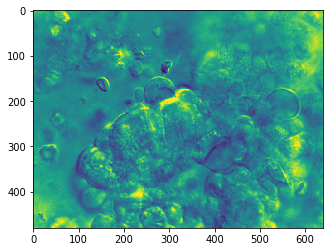

In [33]:
print (test_a.shape)
plt.imshow(test_a[0, 2, :, :])

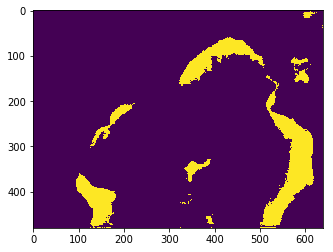

In [39]:
pred_a[pred_a==1] = 0
plt.imshow(pred_a[0, :, :])
pred_a = pred_a[0, :, :]
# print(pred_a.numpy())
# np.savetxt(test_dir[0] + '.png', pred_a.numpy(), fmt='%i')
# from scipy.misc import imsave
imwrite('outfile.jpg', pred_a.numpy().astype(np.uint8))

        

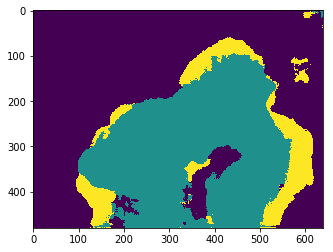

In [28]:
plt.imshow(pred_a[0, :, :])

In [29]:
test_res = pred_a[0, :, :]

In [24]:

inputs_a, pred_a = training_utils.get_test_results(model, test_loader, 1)

In [27]:
inputs_a.shape, pred_a.shape

(torch.Size([1, 3, 480, 640]), torch.Size([1, 480, 640]))

In [32]:
input_val, target_val = next(iter(val_loader))

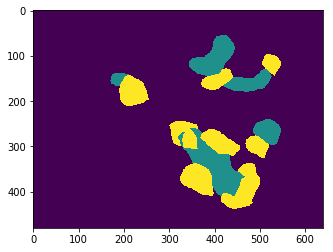

In [33]:
plt.imshow(target_val[0,:,:])

In [43]:
import time
from pathlib import Path

# check (and build) the saved path for storing the results.

RESULTS_PATH = Path('.results/')
WEIGHTS_PATH = Path('.weights/')
RESULTS_PATH.mkdir(exist_ok=True)
WEIGHTS_PATH.mkdir(exist_ok=True)

NameError: name 'RESULTS_PATH' is not defined